In [1]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import os
import random
import io
from os.path import join
import git
import numpy as np
from gym import spaces
import json
import shutil
%matplotlib inline
from matplotlib import pyplot as plt

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

from PIL import Image
from loguru import logger
import habitat
from habitat.core.logging import logger
from habitat.core.registry import registry
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.tasks.nav.nav import NavigationTask
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.config.default import get_config as get_baselines_config

/opt/conda/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Neither `ifconfig` (`ifconfig -a`) nor `ip` (`ip address show`) commands are available, listing network interfaces is likely to fail


In [2]:
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import HeadingSensorConfig, TopRGBSensorConfig, TopDownMapMeasurementConfig, FogOfWarConfig, CollisionsMeasurementConfig
from habitat.config import read_write
from habitat.utils.visualizations.utils import (
    images_to_video,
    observations_to_image,
    overlay_frame,
)

In [3]:
from habitat.utils.visualizations import maps


In [4]:
import habitat_sim

In [5]:
def recompute_navmesh(sim):
    # recompute the NavMesh with STATIC objects
    navmesh_settings = habitat_sim.NavMeshSettings()
    navmesh_settings.set_defaults()
    navmesh_settings.include_static_objects = True
    navmesh_success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)
    assert navmesh_success, "Failed to build static navmesh"

In [6]:
def display_sample(
    rgb_obs
):  # noqa: B006
    rgb_img = Image.fromarray(rgb_obs, mode="RGB")
    return rgb_img

In [7]:
import os
from loguru import logger

import git

import habitat

# # Set paths
# repo = git.Repo(".", search_parent_directories=True)
# dir_path = repo.working_tree_dir
# data_path = os.path.join(dir_path, "data")
# os.chdir(dir_path)
logger.info(f"Inside initialize_env.py: Current working directory: {os.getcwd()}")

import sys
sys.path.append(os.getcwd())
# Add parametrized actions to the config
from examples.random_walk_sim.parametrized_action import add_param_actions

def define_config():
    # Config for HSSD Dataset and DDPPO model with pretrained weights (we don't use this model for now)
    dir_path = os.getcwd()
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-baselines/habitat_baselines/config/objectnav/hssd-200_ver_clip_hssd-hab.yaml"
            # "habitat-lab/habitat/config/benchmark/nav/objectnav/objectnav_hssd-hab.yaml",
        ),
        overrides=[
            # "habitat.environment.iterator_options.shuffle=False",
            "habitat_baselines.eval.split=train",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.height=512",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.width=512",
            # "habitat.simulator.create_renderer=False",
            "habitat.simulator.habitat_sim_v0.enable_hbao=True",
            "habitat.simulator.habitat_sim_v0.enable_physics=True",
            "habitat_baselines.eval.video_option=[\"disk\"]",
            "habitat_baselines.rl.ddppo.pretrained_weights=data/ddppo-models/hssd_pretrained_best_on_hm3d_ckpt.pth",
            "habitat.simulator.habitat_sim_v0.allow_sliding=false",
            # "habitat.environment.iterator_options.num_episode_sample=1",
            # "habitat.environment.iterator_options.shuffle=False" Don't use these two else random episodes won't get generated
        ],
    )
    with read_write(config):
        agent_config = get_agent_config(sim_config=config.habitat.simulator)
        agent_config.sim_sensors.update(
            {"toprgb_sensor": TopRGBSensorConfig(),
            }
        )
        config.habitat.task.measurements.update(
            {
                "top_down_map": TopDownMapMeasurementConfig(
                    map_padding=3,
                    map_resolution=1024,
                    draw_source=False,
                    draw_border=True,
                    draw_shortest_path=False,
                    draw_view_points=False,
                    draw_goal_positions=True,
                    draw_goal_aabbs=False,
                    fog_of_war=FogOfWarConfig(
                        draw=True,
                        visibility_dist=5.0,
                        fov=90,
                    ),
                )
            }
        )
        config.habitat.simulator.agents.main_agent.sim_sensors.toprgb_sensor.height=1920
        config.habitat.simulator.agents.main_agent.sim_sensors.toprgb_sensor.width=1080
    config = add_param_actions(config)        
    return config

class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()
    
def create_env():
    config = define_config()
    dataset = habitat.make_dataset(
        id_dataset=config.habitat.dataset.type, config=config.habitat.dataset, 
    )
    env = SimpleRLEnv(config=config, dataset=dataset)
    return env

2024-06-01 04:35:11.311 | INFO     | __main__:<module>:13 - Inside initialize_env.py: Current working directory: /data/reventh/habitat-lab


In [8]:
define_config()

{'habitat_baselines': {'evaluate': False, 'trainer_name': 'ver', 'updater_name': 'PPO', 'distrib_updater_name': 'DDPPO', 'torch_gpu_id': 0, 'tensorboard_dir': 'data/training/objectnav/hssd-hab/tb', 'writer_type': 'tb', 'video_dir': 'data/training/objectnav/hssd-hab/video_dir', 'video_fps': 10, 'test_episode_count': -1, 'eval_ckpt_path_dir': 'data/training/objectnav/hssd-hab/checkpoints/', 'num_environments': 24, 'num_processes': -1, 'rollout_storage_name': 'RolloutStorage', 'checkpoint_folder': 'data/training/objectnav/hssd-hab/checkpoints', 'num_updates': 270000, 'num_checkpoints': 500, 'checkpoint_interval': -1, 'total_num_steps': -1.0, 'log_interval': 10, 'log_file': 'train.log', 'force_blind_policy': False, 'verbose': True, 'vector_env_factory': {'_target_': 'habitat_baselines.common.HabitatVectorEnvFactory'}, 'evaluator': {'_target_': 'habitat_baselines.rl.ppo.habitat_evaluator.HabitatEvaluator'}, 'eval_keys_to_include_in_name': [], 'force_torch_single_threaded': True, 'wb': {'pro

In [9]:
env = create_env()

2024-06-01 04:35:14,346 Initializing dataset ObjectNav-v1
2024-06-01 04:35:28,294 initializing sim Sim-v0
2024-06-01 04:35:31,017 Initializing task ObjectNav-v1


In [10]:
def draw_top_down_map(info, size):
    top_down_map_key = "top_down_map"
    if top_down_map_key in info:
        top_down_map = maps.colorize_draw_agent_and_fit_to_height(
            info[top_down_map_key], size
        )
    fig = plt.figure()
    img = plt.imshow(top_down_map)
    plt.close(fig)
    return img.get_array().filled(fill_value=0)

In [11]:
def get_3drendered_top_down_map(env):
    top_down_map = maps.get_topdown_map_from_sim(env.habitat_env.sim)
    z, x = maps.from_grid(top_down_map.shape[0]//2, top_down_map.shape[1]//2, top_down_map.shape, env.habitat_env.sim)
    pos, _ = env.habitat_env.sim.get_agent_state().position, env.habitat_env.sim.get_agent_state().rotation
    obs = env.step({'action': 'param_change_loc', 'action_args': {'pos_crd': np.array([x, pos[1], z]), 'angle_crd': np.array([0.0, 1.0, 0.0, 0.0])}})[0]
    logger.info(f"{obs.keys()}")
    img = display_sample(obs["top_rgb"])
    bbox = img.getbbox()
    return img.crop(bbox)

In [12]:
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower


In [13]:
actionmap = {v: k for k, v in HabitatSimActions._known_actions.items()}

In [14]:
type(env.habitat_env.current_episode.goals)

list

In [15]:
# env.step({"action":"param_change_loc", "action_args": {"pos_crd": default_spawn[0], "angle_crd": default_spawn[1]}})
def generate_path_traversal_data(env):
    images = []
    traversal = []
    actions = []
    isfirst = True
    goal = env.habitat_env.current_episode.goals[0]
    logger.info(f"Goal: {goal}")
    goal_radius = goal.radius
    if goal_radius is None:
        goal_radius = 0.25
    follower = ShortestPathFollower(
        env.habitat_env.sim, goal_radius, False
    )
    logger.info(f"Goal: {goal}")
    startpos, startrot = env.habitat_env.current_episode.start_position, env.habitat_env.current_episode.start_rotation
    observations, reward, done, info = env.step({'action': 'param_change_loc', 'action_args': {'pos_crd': startpos, 'angle_crd': startrot}})
    while not env.habitat_env.episode_over:
        best_action = follower.get_next_action(
            goal.view_points[0].agent_state.position

        )
        if best_action is None:
            break
        im = observations["rgb"]    
        if isfirst:
            tdv = draw_top_down_map(env.habitat_env.get_metrics(), size=im.shape[0])
            isfirst = False
        else:
            tdv = draw_top_down_map(info, size=im.shape[0])
        images.append(im)
        traversal.append(tdv)
        actions.append(actionmap[best_action])
        observations, reward, done, info = env.step(best_action)
        # path.append((env.habitat_env.sim.get_agent_state().position, env.habitat_env.sim.get_agent_state().rotation))
        # print(info)
    images.append(im)
    traversal.append(tdv)
    return goal.object_category, images, traversal, actions

In [16]:
def save_episode_data(savelocation, images, traversal, actions):
    savepaths_rgb = []
    savepaths_topdown = []
    for i, (im, tdv, action) in enumerate(zip(images, traversal, actions)):
        Image.fromarray(im.astype(np.uint8)).save(f"{savelocation}/image_{i}.png")
        Image.fromarray(tdv.astype(np.uint8)).save(f"{savelocation}/top_down_map_{i}.png")
        savepaths_rgb.append(f"{savelocation}/image_{i}.png")
        savepaths_topdown.append(f"{savelocation}/top_down_map_{i}.png")
    return savepaths_rgb, savepaths_topdown

In [17]:
def create_data(savelocation, topdown3drender, targetobj, images, traversal, actions):
    if os.path.exists(savelocation):
        shutil.rmtree(savelocation)
    os.makedirs(savelocation)
    topdown3drender.save(f"{savelocation}/top_down_map_3drender.png")
    savepaths_rgb, savepaths_topdown = save_episode_data(savelocation, images, traversal, actions)
    images_to_video(images, f"{savelocation}/trajectoryvideo", "rgb_traj")
    images_to_video(traversal, f"{savelocation}/trajectoryvideo", "topdown_traj")
    data = {"target_object": targetobj, "video_rgb_traj":f"{savelocation}/trajectoryvideo/rgb_traj.mp4", "video_topdown_traj":f"{savelocation}/trajectoryvideo/topdown_traj.mp4", "env_topdown_3d_render": f"{savelocation}/top_down_map_3drender.png", "source_rgb": savepaths_rgb[0], "source_topdown": savepaths_topdown[0], "actions": actions, "targets_rgb": savepaths_rgb[1:], "targets_topdown": savepaths_topdown[1:]}
    return data

In [20]:
i = 0
N = 10
env.habitat_env._episode_from_iter_on_reset = False
obs = env.reset()
data = []
for ep in env.habitat_env._episode_iterator:
    if i>N:
        break
    env.habitat_env.current_episode = ep
    env.reset()
    recompute_navmesh(env.habitat_env.sim)
    topdown3drender = get_3drendered_top_down_map(env)
    goal_cat, images, traversal, actions = generate_path_traversal_data(env)
    data.append(create_data(f"{os.getcwd()}/data/episode_{i}", topdown3drender, goal_cat, images, traversal, actions))
    i += 1

2024-06-01 04:38:03.430 | INFO     | __main__:get_3drendered_top_down_map:6 - dict_keys(['rgb', 'depth', 'top_rgb', 'objectgoal', 'compass', 'gps'])
2024-06-01 04:38:03.459 | INFO     | __main__:generate_path_traversal_data:8 - Goal: ObjectGoal(position=[-15.64935, 0.38545, -2.48578], radius=None, object_id=118, object_name='5f436be29314cec131bdedaea822e70dcb7a7891_:0000', object_name_id=None, object_category='toilet', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.21363], rotation=[0.0, 0.49726, 0.0, 0.8676]), iou=0.29581), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.12363], rotation=[0.0, 0.39045, 0.0, 0.92062]), iou=0.28302), ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.12363], rotation=[0.0, 0.43885, 0.0, 0.89856]), iou=0.26681), ObjectViewLocation(agent_state=AgentState(position=[-15.36479, 0.13964, -2.03363], rotation=[0.0, 0.27718, 0.0, 0.96082]), i

In [21]:
with open(f"{os.getcwd()}/data/data.json", "w") as f:
        json_str = json.dumps(data)
        f.write(json_str)

In [19]:
tdv = draw_top_down_map(info, 512)
Image.fromarray(tdv.astype(np.uint8))

NameError: name 'info' is not defined

In [ ]:
info = env.habitat_env.get_metrics()

In [ ]:
obs = env.reset()

In [ ]:
startpos, startrot = env.habitat_env.current_episode.start_position, env.habitat_env.current_episode.start_rotation
observations, reward, done, info = env.step({'action': 'param_change_loc', 'action_args': {'pos_crd': startpos, 'angle_crd': startrot}})


In [ ]:
info

{'distance_to_goal': 2.961380958557129,
 'success': 0.0,
 'spl': 0.0,
 'soft_spl': 0.0,
 'distance_to_goal_reward': -0.0,
 'top_down_map': {'map': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'fog_of_war_mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'agent_map_coord': [(1192, 718)],
  'agent_angle': [array(-0.38825262)]}}

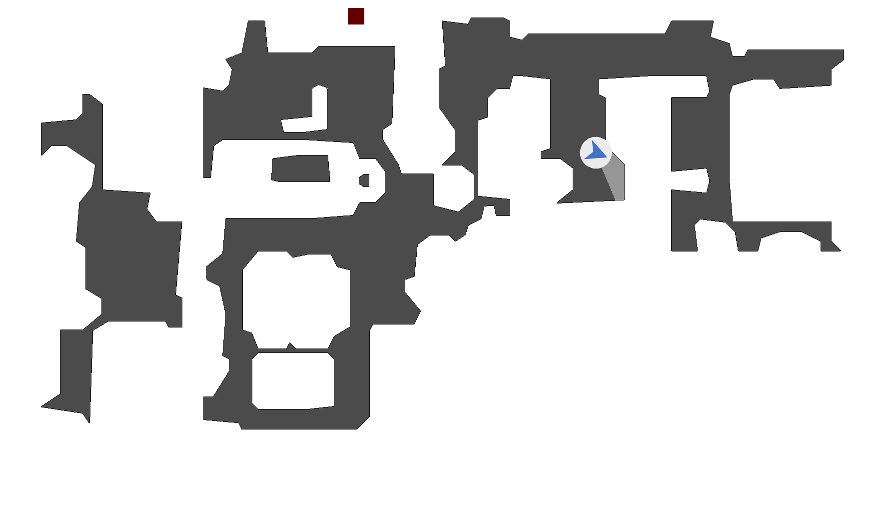

In [ ]:
tdv = draw_top_down_map(info, 512)
Image.fromarray(tdv.astype(np.uint8))

In [25]:
obs = env.reset()

In [26]:
cat, images, traversal, actions, iskimaka = generate_path_traversal_data(env)

2024-06-01 03:07:12.870 | INFO     | __main__:generate_path_traversal_data:8 - Goal: ObjectGoal(position=[-16.96485, 0.42782, -4.07402], radius=None, object_id=8, object_name='0070649630e7b2262ec0427c0e2035232240fb4d_:0000', object_name_id=None, object_category='chair', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-16.42584, 0.13964, -3.89361], rotation=[0.0, 0.58421, 0.0, 0.8116]), iou=0.27445), ObjectViewLocation(agent_state=AgentState(position=[-16.42584, 0.13964, -3.98361], rotation=[0.0, 0.64598, 0.0, 0.76336]), iou=0.27198), ObjectViewLocation(agent_state=AgentState(position=[-16.42584, 0.13964, -3.80361], rotation=[0.0, 0.52516, 0.0, 0.851]), iou=0.26535), ObjectViewLocation(agent_state=AgentState(position=[-16.42584, 0.13964, -4.07361], rotation=[0.0, 0.70684, 0.0, 0.70738]), iou=0.25777), ObjectViewLocation(agent_state=AgentState(position=[-16.60584, 0.13964, -4.61361], rotation=[0.0, 0.95722, 0.0, 0.28935]), iou=0.24147), Obje

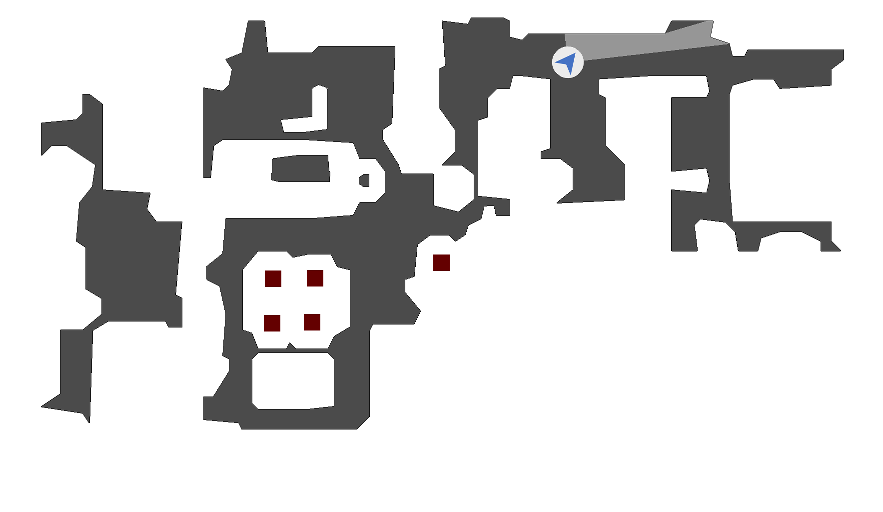

In [29]:
# tdv = draw_top_down_map(iskimaka, 512)
Image.fromarray(iskimaka.astype(np.uint8))

In [28]:
iskimaka

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]